In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns

In [2]:
class Model:
    def __init__(self, neuron, n_neurons=1):
        self.neuron = neuron
        self.n_neurons = n_neurons
        self.dt: float
        self.measurement_time: list = [0]
        self.next_neuron_time: list = [0]
        self.measured_mV: list = [self.neuron.mV]
        self.measured_gate_states: list = [self.neuron.gates]
        self.dur: float = 5
        self.init_mV: list = [neuron.mV]
        self.init_gate_states: list = [neuron.gates]

    def init_n_neurons(self, num_meth_gates, num_meth_mV, dt=0.01):
        # run with equilibrium values for 100 mseconds
        n_neurons_temp = self.n_neurons
        self.run(run_time_neuron=150, num_meth_gates=num_meth_gates, num_meth_mV=num_meth_mV, mV_AP=np.inf, dt=dt)
        self.n_neurons = n_neurons_temp
        init_indices = np.random.randint(np.argmax(np.array(self.measurement_time) > 100), len(self.measurement_time), self.n_neurons)
        self.init_mV = np.array(self.measured_mV)[init_indices]
        self.init_gate_states = np.array(self.measured_gate_states)[init_indices]
        
        # reset
        self.measurement_time: list = [0]
        self.next_neuron_time: list = [0]
        self.measured_mV: list = [self.init_mV[0]]
        self.measured_gate_states: list = [self.init_gate_states[0]]
        self.neuron.update_trans_rates()

    def applied_current(self):
        if self.measurement_time[-1] < self.next_neuron_time[-1] + self.dur:
            self.neuron.I = np.random.normal(9,0.05)
        else:
            self.neuron.I = np.random.normal(0,0.05)

    def run(self, run_time_neuron, num_meth_gates, num_meth_mV, mV_AP=30, dt=0.01):        
        assert isinstance(run_time_neuron, (int, float)) and run_time_neuron > 0, \
        'the run time per neuron should be a positive number'
        assert num_meth_gates == self.euler_step_gates or num_meth_gates == self.RK_step_gates or num_meth_gates == self.gillespie_step_gates, \
        'numerical method for the gates should be YOUR_MODEL.euler_step_gates, YOUR_MODEL.RK_step_gates or YOUR_MODEL.gillespie_step_gates'
        assert num_meth_mV == self.euler_step_mV or num_meth_mV == self.RK_step_mV, \
        'numerical method for mV should be YOUR_MODEL.euler_step_mV or YOUR_MODEL.RK_step_mV'
        assert isinstance(mV_AP, (int, float)), \
        'the mV which you use to check if an action potential has been fired, should be a number'
        assert isinstance(self.n_neurons, (int, float)) and self.n_neurons > 0, \
        'the number of neurons in the network should be a positive number'
        assert isinstance(dt, (int, float)) and dt > 0, \
        'dt must be a positive number'
        if num_meth_gates == self.gillespie_step_gates:
            assert self.neuron.channel_states, \
            'when using gillespie_step_gates, channel_states has to be true'
        if num_meth_gates == self.euler_step_gates or num_meth_gates == self.RK_step_gates:
            assert not self.neuron.channel_states, \
            'when using euler_step_gates or RK_step_gates, channel_states has to be false'

        self.dt = dt
        
        # flag 
        stop = False

        for i in range(self.n_neurons):
            # init neuron
            self.neuron.mV = self.init_mV[i]
            self.neuron.gates = self.init_gate_states[i]
            # en init nog de andere np array

            while True:
                # get applied current for current time
                self.applied_current()

                # compute new gate states
                num_meth_gates()

                # compute new channel states from gate states
                self.neuron.update_channels()

                # compute new mV
                num_meth_mV()

                # compute new gate transition rates given the new mV
                self.neuron.update_trans_rates()

                # measure new state
                self.measurement_time.append(self.measurement_time[-1] + self.dt)
                self.measured_mV.append(self.neuron.mV)
                self.measured_gate_states.append(self.neuron.gates.copy())                
            
                if mV_AP < self.neuron.mV:
                    self.next_neuron_time.append(self.measurement_time[-1])
                    break
                elif self.measurement_time[-1] - self.next_neuron_time[-1] > run_time_neuron:
                    stop = True
                    break
            if stop:
                break

    def gillespie_step_gates(self, channel_states=True):      
        # compute effective rates of changes (save in a_dict) and total effective rates of change (lambda)
        a_dict = self.neuron.get_a_dict()
        lam = sum(a_dict.values())

        # stochastically compute dt
        r1 = np.random.uniform(0, 1)
        self.dt = -np.log(r1) / lam

        # stochastically choose a gate transition
        r2 = np.random.uniform(0, lam)
        mu_sum = 0
        for trans in a_dict:
            mu_sum += a_dict[trans]

            if mu_sum > r2:
                channel, state_out, state_in = trans
                self.neuron.gates[channel, state_out] -= 1
                self.neuron.gates[channel, state_in] += 1
                break

    def euler_step_gates(self):
        self.neuron.gates += self.dt * self.neuron.gates_der(self.neuron.gates)

    def euler_step_mV(self):
        self.neuron.mV += self.dt * self.neuron.mV_der(self.neuron.mV)

    def RK_step_gates(self):
        g1 = self.dt * self.neuron.gates_der(self.neuron.gates)
        g2 = self.dt * self.neuron.gates_der(self.neuron.gates + g1 / 2)
        g3 = self.dt * self.neuron.gates_der(self.neuron.gates + g2 / 2)
        g4 = self.dt * self.neuron.gates_der(self.neuron.gates + g3)
        self.neuron.gates += (1 / 6) * (g1 + 2 * g2 + 2 * g3 + g4)

    def RK_step_mV(self):
        v1 = self.dt * self.neuron.mV_der(self.neuron.mV)
        v2 = self.dt * self.neuron.mV_der(self.neuron.mV + v1 / 2)
        v3 = self.dt * self.neuron.mV_der(self.neuron.mV + v2 / 2)
        v4 = self.dt * self.neuron.mV_der(self.neuron.mV + v3)
        self.neuron.mV += (1 / 6) * (v1 + 2 * v2 + 2 * v3 + v4)

In [3]:
class Neuron:
    def __init__(self, channel_densities: list, ttx=0, area=10, mV=-65, channel_states=False):
        self.ttx = ttx
        self.mV = mV
        self.Cm: float = 1
        self.Cm2: float = 24.3/30                         # membrane capacitance (microF/cm**2)
        self.I = 0                                        # applied current (nA)                               

        self.channel_states = channel_states
        
        self.non_zero_densities = np.array(channel_densities) > 0
        self.channel_densities = np.array(channel_densities)[self.non_zero_densities]
        self.conductances = np.array([36, 120, 0.3, 106.6439, 242.7124, 2.1, 35.135, 6.9005, 0.14])[self.non_zero_densities]
        self.r_potentials = np.array([-77, 50, -54.4, 50, 50, -92.34, 62.94, 62.94, -54.3])[self.non_zero_densities]
        self.ttx_blockage = np.array([1, 1, 1, self.inhibition_ttx(), 1, 1, self.inhibition_ttx(), 1, 1])[self.non_zero_densities]

        if self.channel_states:
            self.n_channels = (np.array(channel_densities) * area)[self.non_zero_densities]
            self.last_configs = np.array([4, 7, 0, 15, 31, 1, 7, 3, 0])[self.non_zero_densities]
            max_last_configs = self.last_configs.max()
            quotients = self.n_channels // (self.last_configs + 1)
            remainders = self.n_channels % (self.last_configs + 1)

            self.gates = np.array([[quotient + remainder] + last_config * [quotient] + (max_last_configs - last_config) * [0]
                                    for quotient, remainder, last_config in zip(quotients, remainders, self.last_configs)])
        else:
            self.n_gates = np.array([[4, 0, 0, 0], 
                                     [3, 1, 0, 0], 
                                     [1, 0, 0, 0],
                                     [3, 1, 1, 0],
                                     [3, 1, 1, 1],
                                     [1, 0, 0, 0],
                                     [3, 1, 0, 0],
                                     [1, 1, 0, 0],
                                     [1, 0, 0, 0]
                                     ])[self.non_zero_densities]
            self.gates = np.array([[0.5, 0, 0, 0],
                                   [0.5, 0.5, 0, 0],
                                   [1, 0, 0, 0],
                                   [0.5, 0.5, 0.5, 0],
                                   [0.5, 0.5, 0.5, 0.5],
                                   [0.5, 0, 0, 0],
                                   [0.5, 0.5, 0, 0],
                                   [0.5, 0.5, 0, 0],
                                   [1, 0, 0, 0]
                                   ])[self.non_zero_densities]

        max_n_gates_per_channel = 4
        self.trans_rates = np.zeros(shape=(len(self.channel_densities), max_n_gates_per_channel, 2))
        self.channels = np.zeros_like(self.channel_densities)
        self.update_trans_rates()
        self.update_channels()


    def update_trans_rates(self):
        i = 0
        if self.non_zero_densities[0]:
            # update alpha_n and beta_n for the HH potassium channel
            self.trans_rates[i,0,0] = (0.01 * (self.mV + 55)) / (1 - np.exp(-(self.mV + 55) / 10))
            self.trans_rates[i,0,1] = 0.125 * np.exp(-(self.mV + 65 ) / 80)
            i += 1
        if self.non_zero_densities[1]:
            # update alpha_m and beta_m for the HH sodium channel
            self.trans_rates[i,0,0] = (0.1 * (self.mV + 40)) / (1 - np.exp(-(self.mV + 40) / 10))
            self.trans_rates[i,0,1] =  4 * np.exp(-(self.mV + 65) / 18)

            # update alpha_h and beta_h for the HH sodium channel
            self.trans_rates[i,1,0] = 0.07 * np.exp(-(self.mV + 65) / 20)
            self.trans_rates[i,1,1] = 1 / (1 + np.exp(-(self.mV + 35) / 10))
            i += 1

        # skip self.non_zero_densities[2], since the leakage channel doesn't change state
        
        if self.non_zero_densities[3]:
            # alpha_m and beta_m for channel 1.7
            self.trans_rates[i, 0, 0] = 15.5 / (1 + np.exp((self.mV - 5)/ -12.08))
            self.trans_rates[i, 0, 1] = 35.2 / (1 + np.exp((self.mV + 72.7)/ 16.7))
            
            # alpha_h and beta_h
            self.trans_rates[i, 1, 0] = 0.38685 / (1 + np.exp((self.mV + 122.35)/ 15.29))
            self.trans_rates[i, 1, 1] = -0.00283 + (2.00283 / (1 + np.exp((self.mV + 5.5266)/-12.70195)))

            # alpha_s and beta_s
            self.trans_rates[i, 2, 0] = 0.00003 + (0.00092 / (1 + np.exp((self.mV + 93.9)/ 16.6)))
            self.trans_rates[i, 2, 1] = 132.05 - (132.05/ (1 + np.exp((self.mV + 384.9)/ 28.5)))
            i += 1
        if self.non_zero_densities[4]:
            #alpha_m and beta_m for channel 1.8
            self.trans_rates[i, 0, 0] = 2.85 - (2.839/ (1 + np.exp((self.mV - 1.159)/ 13.95)))
            self.trans_rates[i, 0, 1] = 7.6205 / (1 + np.exp((self.mV + 46.463)/ 8.8289))

            # alpha_s and beta_s
            self.trans_rates[i, 1, 0] = 0.001 * (5.4203 / (1 + np.exp((self.mV + 79.816)/ 16.269)))
            self.trans_rates[i, 1, 1] = 0.001 * (5.0757 / (1 + np.exp((-self.mV + -15.968)/ 11.542)))

            # alpha_u and beta_u
            self.trans_rates[i, 2, 0] = 0.0002 * (2.0434 / (1 + np.exp((self.mV + 67.499)/ 19.51)))
            self.trans_rates[i, 2, 1] = 0.0002 * (1.9952 / (1 + np.exp((self.mV + 30.963)/ 14.792)))
            i += 1
        if self.non_zero_densities[5]:
            # alpha_n, beta_n for second paper (HH sodium channel)
            self.trans_rates[i,0,0] = 0.001265 * (self.mV + 14.273) / (1 - np.exp((self.mV + 14.273) / -10))
            self.trans_rates[i,0,1] = 0.125 * np.exp((self.mV + 55) / -2.5)
            i += 1
        if self.non_zero_densities[6]:
            # alpha_m, beta_m TTX sensitive
            self.trans_rates[i,0,0] = 11.49 / (1 + np.exp((self.mV + 8.58) / -8.47))
            self.trans_rates[i,0,1] = 11.49 / (1 + np.exp((self.mV + 67.2) / 27.8))

            # alpha_h, beta_h TTX sensitive
            self.trans_rates[i,1,0] = 0.0658 * np.exp(-(self.mV + 120) / 20.33)
            self.trans_rates[i,1,1] = 3.0 / (1 + np.exp((self.mV - 6.8) / -12.998))
            i += 1
        if self.non_zero_densities[7]:
            # alpha_m, beta_m TTX resistant
            self.trans_rates[i,0,0] = 1.032 / (1 + np.exp((self.mV + 6.99) / -14.87115))
            self.trans_rates[i,0,1] = 0.13496 / (1 + np.exp((self.mV + 10.27853) / -9.09334))
            
            # alpha_h, beta_h TTX resistant
            self.trans_rates[i,1,0] = 0.06435 / (1 + np.exp((self.mV + 73.26415) / 3.71928))
            self.trans_rates[i,1,1] = 5.79 / (1 + np.exp((self.mV + 130.4) / 22.9))
            i += 1

    def update_channels(self):
        if self.channel_states:
            self.channels = self.gates[np.arange(len(self.last_configs)), self.last_configs] / self.n_channels
        else:
            self.channels = np.prod(self.gates ** self.n_gates, axis=1) 

    def inhibition_ttx(self):
        if self.ttx <= 0:
            return 1

        if False: 
            intercept, slope = 0.8364295364138072, -0.005809421301242236
            perc = intercept + slope * np.log10(self.ttx)
            if perc < 0:
                
                return 0
            else:
            
                return perc
        
        else:
            intercept, slope = -3.4864276002719228, -0.4194085656016315
            perc = intercept + slope * np.log10(self.ttx)
            if perc < 0:
                return 0
            else:
                return perc

    def get_a_dict(self, channel_states=True):
        a_dict = {}
        i = 0
        if self.non_zero_densities[0]:
            for j, (state1, state2) in enumerate(zip(self.gates[i, :4], self.gates[i, 1:5]), 1): 
                a_dict[(i, j - 1, j)] = state1 * (5 - j) * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * j * self.trans_rates[i, 0, 1]
            i += 1

        if self.non_zero_densities[1]:
            for j, (state1, state2, state3, state4) in enumerate(zip(self.gates[i, :3], self.gates[i, 1:4], 
                                                                    self.gates[i, 4:7], self.gates[i, 5:8]), 1):
                a_dict[(i, j - 1, j)] = state1 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 3, j + 4)] = state3 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 4, j + 3)] = state4 * (4 - j) * self.trans_rates[i, 0, 1]

                a_dict[(i, j - 1, j + 3)] = state1 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 3, j - 1)] = state3 * self.trans_rates[i, 1, 1]

            a_dict[(i, 3, 7)] = self.gates[i, 3] * self.trans_rates[i, 1, 0]
            a_dict[(i, 7, 3)] = self.gates[i, 7] * self.trans_rates[i, 1, 1]
            i += 1

        # skip self.non_zero_densities[2], since the leakage channel doesn't change state

        if self.non_zero_densities[3]:
            for j, (state1, state2, state3, state4, state5, state6, state7, state8) in enumerate(zip(
                                                                                    self.gates[i, :3], self.gates[i, 1:4], 
                                                                                    self.gates[i, 4:7], self.gates[i, 5:8],
                                                                                    self.gates[i, 8:11], self.gates[i, 9:12], 
                                                                                    self.gates[i, 12:15], self.gates[i, 13:16]), 1):
                # a m gate opens or closes
                a_dict[(i, j - 1, j)] = state1 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 3, j + 4)] = state3 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 4, j + 3)] = state4 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 7, j + 8)] = state5 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 8, j + 7)] = state6 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 11, j + 12)] = state7 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 12, j + 11)] = state8 * (4 - j) * self.trans_rates[i, 0, 1]

                # a h gate opens or closes
                a_dict[(i, j - 1, j + 3)] = state1 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 3, j - 1)] = state3 * self.trans_rates[i, 1, 1]
                a_dict[(i, j + 7, j + 8)] = state5 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 8, j + 7)] = state7 * self.trans_rates[i, 1, 1]

                # a s gate opens or closes
                a_dict[(i, j - 1, j + 7)] = state1 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 7, j - 1)] = state5 * self.trans_rates[i, 2, 1]
                a_dict[(i, j + 3, j + 11)] = state3 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 11, j + 3)] = state7 * self.trans_rates[i, 2, 1]

            a_dict[(i, 3, 7)] = self.gates[i, 3] * self.trans_rates[i, 1, 0]
            a_dict[(i, 7, 3)] = self.gates[i, 7] * self.trans_rates[i, 1, 1]
            a_dict[(i, 11, 15)] = self.gates[i, 11] * self.trans_rates[i, 1, 0]
            a_dict[(i, 15, 11)] = self.gates[i, 15] * self.trans_rates[i, 1, 1]

            a_dict[(i, 3, 11)] = self.gates[i, 3] * self.trans_rates[i, 2, 0]
            a_dict[(i, 11, 3)] = self.gates[i, 11] * self.trans_rates[i, 2, 1]
            a_dict[(i, 7, 15)] = self.gates[i, 7] * self.trans_rates[i, 2, 0]
            a_dict[(i, 15, 7)] = self.gates[i, 15] * self.trans_rates[i, 2, 1]
            i += 1
        
        if self.non_zero_densities[4]:
            for j, (state1, state2, state3, state4, state5, state6, state7, state8,
                    state9, state10, state11, state12, state13, state14, state15, state16) in enumerate(zip(
                                                                                            self.gates[i, :3], self.gates[i, 1:4], 
                                                                                            self.gates[i, 4:7], self.gates[i, 5:8],
                                                                                            self.gates[i, 8:11], self.gates[i, 9:12], 
                                                                                            self.gates[i, 12:15], self.gates[i, 13:16],
                                                                                            self.gates[i, 16:19], self.gates[i, 17:20], 
                                                                                            self.gates[i, 20:23], self.gates[i, 21:24],
                                                                                            self.gates[i, 24:27], self.gates[i, 25:28], 
                                                                                            self.gates[i, 28:31], self.gates[i, 29:32]), 1):
                # a m gate opens or closes
                a_dict[(i, j - 1, j)] = state1 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 3, j + 4)] = state3 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 4, j + 3)] = state4 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 7, j + 8)] = state5 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 8, j + 7)] = state6 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 11, j + 12)] = state7 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 12, j + 11)] = state8 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 15, j + 16)] = state9 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 16, j + 15)] = state10 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 19, j + 20)] = state11 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 20, j + 19)] = state12 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 23, j + 24)] = state13 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 24, j + 23)] = state14 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 27, j + 28)] = state15 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 28, j + 27)] = state16 * (4 - j) * self.trans_rates[i, 0, 1]

                # a h gate opens or closes
                a_dict[(i, j - 1, j + 3)] = state1 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 3, j - 1)] = state3 * self.trans_rates[i, 1, 1]
                a_dict[(i, j + 7, j + 8)] = state5 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 8, j + 7)] = state7 * self.trans_rates[i, 1, 1]

                a_dict[(i, j + 15, j + 19)] = state9 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 19, j + 15)] = state11 * self.trans_rates[i, 1, 1]
                a_dict[(i, j + 23, j + 24)] = state13 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 24, j + 23)] = state15 * self.trans_rates[i, 1, 1]

                # a s gate opens or closes
                a_dict[(i, j - 1, j + 7)] = state1 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 7, j - 1)] = state5 * self.trans_rates[i, 2, 1]
                a_dict[(i, j + 3, j + 11)] = state3 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 11, j + 3)] = state7 * self.trans_rates[i, 2, 1]
                a_dict[(i, j + 15, j + 23)] = state9 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 23, j + 15)] = state13 * self.trans_rates[i, 2, 1]
                a_dict[(i, j + 19, j + 27)] = state11 * self.trans_rates[i, 2, 0]
                a_dict[(i, j + 27, j + 19)] = state15 * self.trans_rates[i, 2, 1]

                # a u gate opens or closes
                a_dict[(i, j - 1, j + 15)] = state1 * self.trans_rates[i, 3, 0]
                a_dict[(i, j + 15, j - 1)] = state9 * self.trans_rates[i, 3, 1]
                a_dict[(i, j + 3, j + 19)] = state3 * self.trans_rates[i, 3, 0]
                a_dict[(i, j + 19, j + 3)] = state11 * self.trans_rates[i, 3, 1]
                a_dict[(i, j + 7, j + 23)] = state5 * self.trans_rates[i, 3, 0]
                a_dict[(i, j + 23, j + 15)] = state13 * self.trans_rates[i, 3, 1]
                a_dict[(i, j + 11, j + 27)] = state7 * self.trans_rates[i, 3, 0]
                a_dict[(i, j + 27, j + 11)] = state15 * self.trans_rates[i, 3, 1]

            a_dict[(i, 3, 7)] = self.gates[i, 3] * self.trans_rates[i, 1, 0]
            a_dict[(i, 7, 3)] = self.gates[i, 7] * self.trans_rates[i, 1, 1]
            a_dict[(i, 11, 15)] = self.gates[i, 11] * self.trans_rates[i, 1, 0]
            a_dict[(i, 15, 11)] = self.gates[i, 15] * self.trans_rates[i, 1, 1]
            a_dict[(i, 19, 23)] = self.gates[i, 19] * self.trans_rates[i, 1, 0]
            a_dict[(i, 23, 19)] = self.gates[i, 23] * self.trans_rates[i, 1, 1]
            a_dict[(i, 27, 31)] = self.gates[i, 27] * self.trans_rates[i, 1, 0]
            a_dict[(i, 31, 27)] = self.gates[i, 31] * self.trans_rates[i, 1, 1]

            a_dict[(i, 3, 11)] = self.gates[i, 3] * self.trans_rates[i, 2, 0]
            a_dict[(i, 11, 3)] = self.gates[i, 11] * self.trans_rates[i, 2, 1]
            a_dict[(i, 7, 15)] = self.gates[i, 7] * self.trans_rates[i, 2, 0]
            a_dict[(i, 15, 7)] = self.gates[i, 15] * self.trans_rates[i, 2, 1]
            a_dict[(i, 19, 27)] = self.gates[i, 19] * self.trans_rates[i, 2, 0]
            a_dict[(i, 27, 19)] = self.gates[i, 27] * self.trans_rates[i, 2, 1]
            a_dict[(i, 23, 31)] = self.gates[i, 23] * self.trans_rates[i, 2, 0]
            a_dict[(i, 31, 23)] = self.gates[i, 31] * self.trans_rates[i, 2, 1]

            a_dict[(i, 3, 19)] = self.gates[i, 3] * self.trans_rates[i, 3, 0]
            a_dict[(i, 19, 3)] = self.gates[i, 19] * self.trans_rates[i, 3, 1]
            a_dict[(i, 7, 23)] = self.gates[i, 7] * self.trans_rates[i, 3, 0]
            a_dict[(i, 23, 7)] = self.gates[i, 23] * self.trans_rates[i, 3, 1]
            a_dict[(i, 11, 27)] = self.gates[i, 11] * self.trans_rates[i, 3, 0]
            a_dict[(i, 27, 11)] = self.gates[i, 27] * self.trans_rates[i, 3, 1]
            a_dict[(i, 15, 31)] = self.gates[i, 15] * self.trans_rates[i, 3, 0]
            a_dict[(i, 31, 15)] = self.gates[i, 31] * self.trans_rates[i, 3, 1]
            i += 1
        if self.non_zero_densities[5]:
            a_dict[(i, 0, 1)] = self.gates[i, 0] * self.trans_rates[i, 0, 0]
            a_dict[(i, 1, 0)] = self.gates[i, 1] * self.trans_rates[i, 0, 1]
            i += 1
        if self.non_zero_densities[6]:
            for j, (state1, state2, state3, state4) in enumerate(zip(self.gates[i, :3], self.gates[i, 1:4], 
                                                                    self.gates[i, 4:7], self.gates[i, 5:8]), 1):
                a_dict[(i, j - 1, j)] = state1 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j, j - 1)] = state2 * (4 - j) * self.trans_rates[i, 0, 1]
                a_dict[(i, j + 3, j + 4)] = state3 * j * self.trans_rates[i, 0, 0]
                a_dict[(i, j + 4, j + 3)] = state4 * (4 - j) * self.trans_rates[i, 0, 1]

                a_dict[(i, j - 1, j + 3)] = state1 * self.trans_rates[i, 1, 0]
                a_dict[(i, j + 3, j - 1)] = state3 * self.trans_rates[i, 1, 1]

            a_dict[(i, 3, 7)] = self.gates[i, 3] * self.trans_rates[i, 1, 0]
            a_dict[(i, 7, 3)] = self.gates[i, 7] * self.trans_rates[i, 1, 1]
            i += 1
        if self.non_zero_densities[7]:
            a_dict[(i, 0, 1)] = self.gates[i, 0] * self.trans_rates[i, 0, 0]
            a_dict[(i, 1, 0)] = self.gates[i, 1] * self.trans_rates[i, 0, 1]
            a_dict[(i, 2, 3)] = self.gates[i, 2] * self.trans_rates[i, 0, 0]
            a_dict[(i, 3, 2)] = self.gates[i, 3] * self.trans_rates[i, 0, 1]
            a_dict[(i, 0, 2)] = self.gates[i, 0] * self.trans_rates[i, 1, 0]
            a_dict[(i, 2, 0)] = self.gates[i, 2] * self.trans_rates[i, 1, 1]
            a_dict[(i, 1, 3)] = self.gates[i, 1] * self.trans_rates[i, 1, 0]
            a_dict[(i, 3, 1)] = self.gates[i, 3] * self.trans_rates[i, 1, 1]

        return a_dict

    def gates_der(self, gates):
        return self.trans_rates[:,:,0] * (1  - gates) - self.trans_rates[:,:,1] * gates

    def mV_der(self, mV):
        return (self.I - np.sum(self.ttx_blockage * self.conductances * self.channels * (mV - self.r_potentials))) / self.Cm2

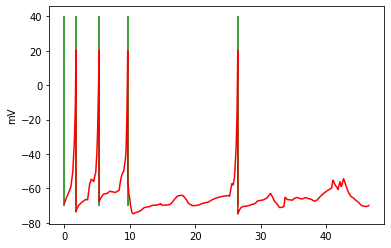

In [6]:
neuron = Neuron((18, 60, 1, 0, 0, 0, 0, 0, 0), channel_states=True, area=10, ttx=0)

model = Model(neuron, 10)

model.init_n_neurons(model.gillespie_step_gates, model.RK_step_mV)

model.run(20, model.gillespie_step_gates, model.RK_step_mV, mV_AP=20)

plt.figure()
plt.plot(model.measurement_time, model.measured_mV, c='r')

plt.vlines(model.next_neuron_time, -70, 40, 'green')
plt.ylabel('mV')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b41179c-5576-4bbe-b1da-6aa3feec5d82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>